# Reproduce Paper Figures

This notebook produces all figures used in the [stingray paper](https://github.com/StingraySoftware/stingraypaper).

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette('colorblind')

import numpy as np

from stingray import sampledata

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
from stingray import Crossspectrum, AveragedCrossspectrum

from stingray.modeling import PSDPosterior, PSDParEst

Let's load some data:

In [4]:
lc = sampledata.sample_data()

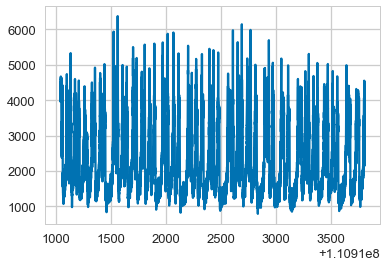

In [6]:
lc.plot()

In [64]:
ps = Powerspectrum(lc, norm="frac")

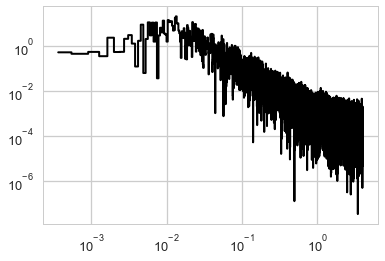

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, ls="steps-mid", lw=2, c="black")

Let's make an averaged periodogram:

In [344]:
# segment size in same time units as light curve object
seg_size = 64.0
# compute averaged power spectrum
avg_ps = AveragedPowerspectrum(lc, seg_size, norm="frac")

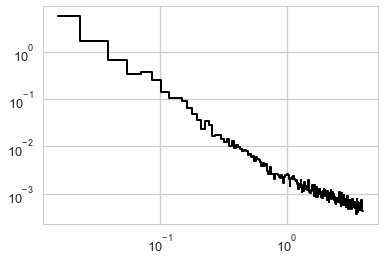

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(avg_ps.freq, avg_ps.power, ls="steps-mid", lw=2, c="black")

In [346]:
ps_log = ps.rebin_log()

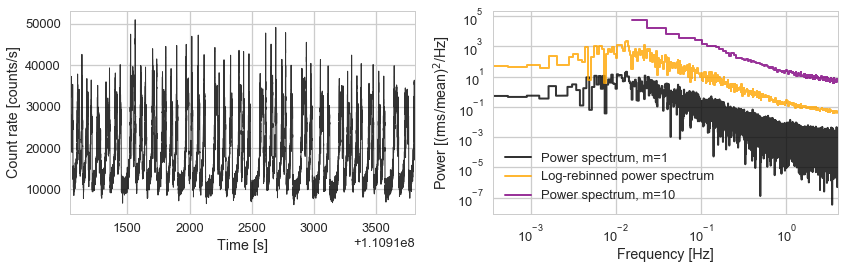

In [347]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))


ax1.plot(lc.time, lc.countrate, lw=1, color="black", linestyle="steps-mid", alpha=0.8)
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Count rate [counts/s]")
ax2.loglog(ps.freq, ps.power, ls="steps-mid", lw=2, c="black", alpha=0.8, 
          label="Power spectrum, m=1")
ax2.loglog(ps_log.freq, ps_log.power*100, ls="steps-mid", lw=2, c="orange", 
          alpha=0.8, label="Log-rebinned power spectrum")

ax2.loglog(avg_ps.freq, avg_ps.power*10000.0, ls="steps-mid", lw=2, c="purple", 
          alpha=0.8, label="Power spectrum, m=10")

ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power [(rms/mean)$^2$/Hz]")
ax2.legend()
fig.tight_layout()

plt.savefig("../tex/example_lc_ps.pdf", format="pdf")


In [348]:
avg_ps.m

43

Let's create a dynamical power spectrum:

In [632]:
# Array of timestamps, 10000 bins from 1s to 100s
times = np.linspace(1,100,10000)

# base component of the lightcurve, poisson-like
# the averaged count-rate is 100 counts/bin
noise = np.random.poisson(100,10000)

# time evolution of the frequency of our fake periodic signal
# the frequency changes with a sinusoidal shape around the value 24Hz
freq = 25 + 1.0*np.sin(2*np.pi*times/130)

# Our fake periodic variability with drifting frequency
# the amplitude of this variability is 10% of the base flux
var = 10*np.sin(2*np.pi*freq*times)

# The signal of our lightcurve is equal the base flux plus the variable flux
signal = noise+var

In [633]:
# Create the lightcurve object
lc = Lightcurve(times, signal)

In [634]:
dps = DynamicalPowerspectrum(lc, segment_size=3)

In [635]:
# By looking into the maximum power of each segment
max_pos = dps.trace_maximum()

In [636]:
import matplotlib.cm as cm

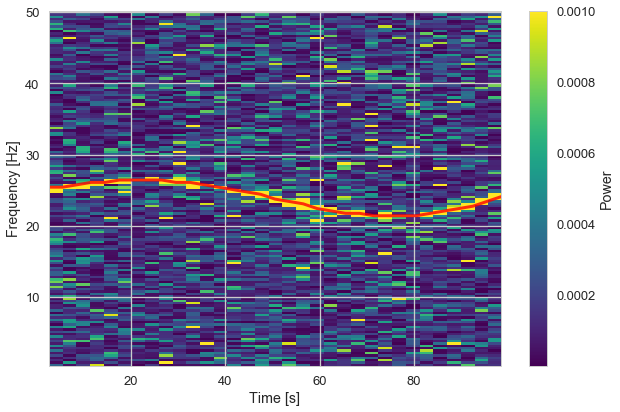

In [637]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

extent = min(dps.time), max(dps.time), min(dps.freq), max(dps.freq)
im = ax.imshow(dps.dyn_ps, aspect="auto", origin="lower", vmax=0.001,
           interpolation="none", extent=extent, cmap=cm.viridis)
ax.plot(dps.time, dps.freq[max_pos], color='red', lw=3, alpha=0.8)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')

fig.colorbar(im, label="Power")
plt.tight_layout()

plt.savefig("../tex/dyn_spec.pdf", format="pdf")

In [589]:
times[1] - times[0]

0.00990099009900991

In [554]:
from stingray import DynamicalPowerspectrum

In [562]:
dps = DynamicalPowerspectrum(lc, segment_size=64.0)

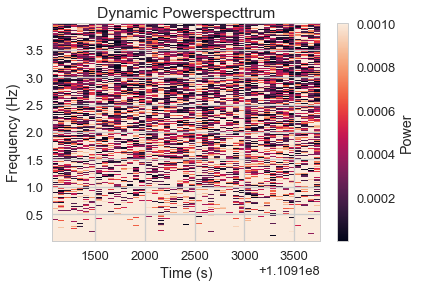

In [563]:
extent = min(dps.time), max(dps.time), min(dps.freq), max(dps.freq)
plt.imshow(dps.dyn_ps, aspect="auto", origin="lower", vmax=0.001,
           interpolation="none", extent=extent)
plt.title('Dynamic Powerspecttrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power')

In [349]:
from stingray.modeling import PSDPosterior, PSDParEst

In [350]:
from astropy.modeling import models

In [368]:
m = models.PowerLaw1D() + models.Const1D()

In [369]:
m.x_0_0.fixed=True

In [370]:
m.fixed

{'alpha_0': False, 'amplitude_0': False, 'amplitude_1': False, 'x_0_0': True}

In [414]:
lpost = PSDPosterior(freq=avg_ps.freq, power=avg_ps.power, model=m, m=avg_ps.m)

In [415]:
lpost.npar

3

In [416]:
import scipy.stats

In [417]:
from stingray.modeling import set_logprior

In [418]:
amp_prior = lambda amp: scipy.stats.uniform(-15, 30).pdf(np.log(amp))
alpha_prior = lambda alpha: scipy.stats.uniform(0,5).pdf(alpha)


priors = {"amplitude_0":amp_prior, 
          "alpha_0":alpha_prior,
          "amplitude_1": amp_prior}

lpost.logprior = set_logprior(lpost, priors)


In [419]:
lpost.logprior([1, 1, 1])

-8.411832675758411

In [420]:
parest = PSDParEst(avg_ps, fitmethod="BFGS", max_post=True)

In [431]:
lpost([0.001, 2, 0.0001])

-33543.569527749074

In [463]:
res = parest.fit(lpost, [0.005, 2, 0.001])

In [464]:
res.p_opt

array([1.71456016e-03, 1.96395121e+00, 4.72065670e-04])

In [465]:
res.result

19001.92219660843

In [466]:
res.p_opt

array([1.71456016e-03, 1.96395121e+00, 4.72065670e-04])

In [467]:
len(res.mfit)

255

In [468]:
len(avg_ps.freq)

255

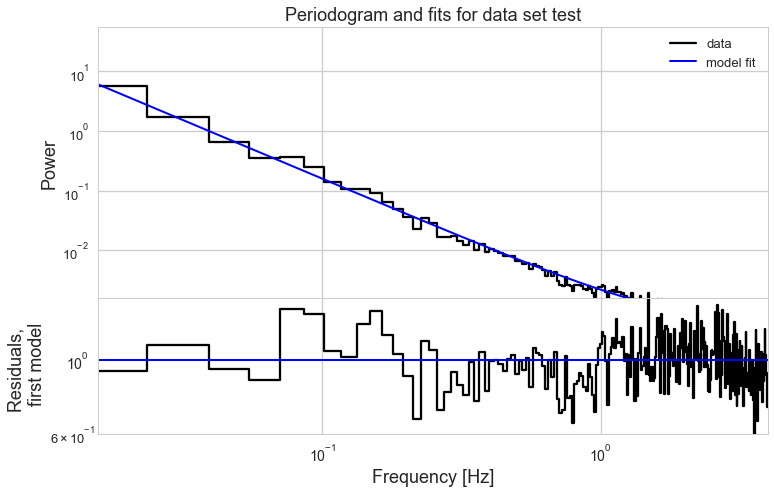

In [469]:
parest.plotfits(res)

In [471]:
sample = parest.sample(lpost, res.p_opt, cov=res.cov, nwalkers=250, niter=200, burnin=1000, threads=1)

-- The acceptance fraction is: 0.651220.5
INFO:MCMC summary:-- The acceptance fraction is: 0.651220.5
R_hat for the parameters is: [1.04539760e-09 1.91089488e-04 1.03776117e-10]
INFO:MCMC summary:R_hat for the parameters is: [1.04539760e-09 1.91089488e-04 1.03776117e-10]
-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO:MCMC summary:---------------------------------------------

theta[0] 	 0.0017137337161497598	3.238666943609524e-05	0.0016602489796422877	0.0017670677805673813

INFO:MCMC summary:theta[0] 	 0.0017137337161497598	3.238666943609524e-05	0.0016602489796422877	0.0017670677805673813

theta[1] 	 1.964864732728005	0.013846368983765506	1.9423382767284725	1.9880883661527275

INFO:MCMC summary:theta[1] 	 1.964864732728005	0.013846368983765506	1.9423382767284725	1.9880883661527275

theta[2] 	 0.0

In [472]:
sample.acceptance

0.65122

In [532]:
samples = sample.samples

In [537]:
samples[:,0] = np.exp(samples[:,0])
samples[:,-1] = np.exp(samples[:,-1])

In [538]:
from astropy.modeling.fitting import _fitter_to_model_params

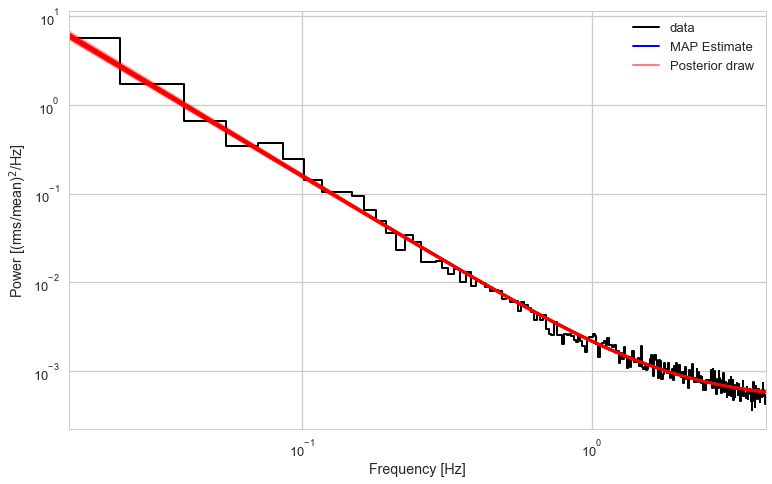

In [548]:
fig, ax = plt.subplots(1, 1, figsize=(11,7))

ax.loglog(avg_ps.freq, avg_ps.power, ls="steps-mid", lw=2, c="black", label="data")
ax.plot(avg_ps.freq, res.mfit, lw=2, color="blue", alpha=1.0, label="MAP Estimate")

ax.set_xlim(avg_ps.freq[0], avg_ps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power [(rms/mean)$^2$/Hz]")

idx = np.random.choice(np.arange(samples.shape[0], dtype=int), replace=False, size=100)

for i, x in enumerate(idx):
    s = samples[x]
    _fitter_to_model_params(m, s)
    ms = m(avg_ps.freq)
    
    if i == 0:
        ax.plot(avg_ps.freq, ms, lw=2, c="red", alpha=0.5, label="Posterior draw")
    else:
        ax.plot(avg_ps.freq, ms, lw=2, c="red", alpha=0.1)
    
ax.legend()
plt.tight_layout()
plt.savefig("../tex/example_posterior.pdf", format='pdf')

In [549]:
import corner

In [550]:
samples[:,0] = np.log(samples[:,0])

In [551]:
samples[:,-1] = np.log(samples[:,-1])

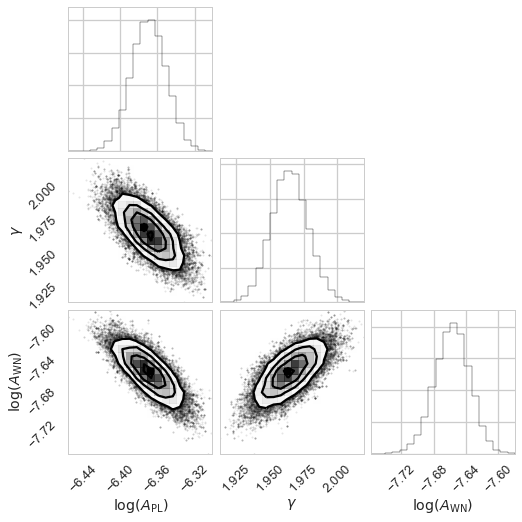

In [553]:
fig = corner.corner(samples, labels=[r"$\log(A_\mathrm{PL})$", r"$\gamma$", r"$\log(A_\mathrm{WN})$"],
                   use_math_text=True, label_kwargs={"labelpad":0.1})

axes = np.array(fig.axes).reshape((3, 3))

plt.savefig("../tex/example_psd_corner.pdf", format="pdf")


In [507]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2e1022e8>,
      dtype=object)

In [85]:
m.parameters

array([1., 1., 1., 1.])